# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [73]:
DATASET = 'GTSRB'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [74]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [83]:
# print available models
model_names = []
for i in (base / 'experiments' / DATASET / 'saved-models').iterdir():
    if i.name[:len(DATASET)] == DATASET:
        model_names.append(i.name.replace(DATASET + '_', ''))
        

model_names.sort(key=lambda x: int(x.split('-')[-1]))
model_names

['AdamW-32-30', 'AdamW-32-50', 'AdamW-32-80', 'AdamW-32-150']

In [86]:
POSTFIX = model_names[0]
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'

FILENAME_POSTFIX

'GTSRB_AdamW-32-30'

In [85]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fastprogress import progress_bar

from utilities.utils import load_json, load_pickle
from utilities.pathManager import fetchPaths
from utilities.MonitorUnifiedBDD import MonitorBDD

# Paths

In [88]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_pca']

# configs = load_json(paths['configuration'])
# config = configs['configuration']
# model_setup = configs['model_setup']
# model_config = configs['model_config']
# optim_name = list(config['optimizer'].keys())[0]
# optim_args = config['optimizer'][optim_name]
# scheduler_name = list(config['scheduler'].keys())[0]
# scheduler_args = config['scheduler'][scheduler_name]

# Seed

In [89]:
np.random.seed(SEED)

# Import Data

In [90]:
FLAVOR = 'raw'

if FLAVOR == 'raw':
    path_lhl = path_lhl_raw
else: path_lhl = path_lhl_pca

# import Data
df_train = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_train.csv")

# select only true classified
df_true = df_train[df_train["true"] == True].copy()
df_true = df_true.drop("true", axis=1).reset_index(drop=True)

df_test = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_test.csv")

# Shuffel and Split indecies

In [92]:
indecies = {}
u_bound = df_true['y'].value_counts().max()
classes = df_true['y'].drop_duplicates().sort_values().values

for c in classes:
    indecies[c] = df_true.loc[df_true['y'] == c].index.values
    np.random.shuffle(indecies[c])

In [93]:
sum([len(i) for i in indecies.values()]) == df_true.shape[0]

True

In [331]:
# periods = 10

# # shuffle data
# schuffled_index = df_true.index.to_numpy().copy()
# np.random.shuffle(schuffled_index)

# # split data into batches
# fragments_index = np.array_split(schuffled_index, periods)

# # print shape
# schuffled_index.shape, np.concatenate(fragments_index).shape

# Build BDD

In [101]:
# each set of data has its own threshold
thld_p = 0.9
eta = 0
neurons = []


# save scores and stats
stats = pd.DataFrame()
train_scores = pd.DataFrame()
test_scores = pd.DataFrame()

# progress bar
pb = progress_bar(range(step, u_bound+start, step))

# number of instances per class
step = 250

# buidl for each i
for i in pb:
    
    # indecies
    ix = np.concatenate([v[:i] for v in indecies.values()], axis=None)
    
    # calculate threshold
    thld = np.quantile( df_true.loc[ix].drop('y', axis=1), thld_p)
    
    # BDD
    patterns = MonitorBDD( df_true.loc[ix].shape[1]-1, thld, neurons=neurons)
    df_train_copy, df_test_copy = patterns.add_dataframe( df_true.loc[ix], eta, eval_dfs=[df_train.loc[ix].copy(), df_test.copy()] )

    
    # score
    df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
    df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)

    
    # add metadata
    patterns.stats['thld'] = f'qth_{thld_p}'
    patterns.stats['period'] = i
    patterns.stats['num_observations'] = ix.shape[0]
    df_train_scores['period'] = i
    df_train_scores['num_observations'] = ix.shape[0]
    df_test_scores['period'] = i
    df_test_scores['num_observations'] = ix.shape[0]
    
    
    # collect scores
    stats = pd.concat([stats, patterns.stats])
    train_scores = pd.concat([train_scores, df_train_scores])
    test_scores = pd.concat([test_scores, df_test_scores])

In [95]:
stats

,thld,eta,build_time,size_mb,reorder_time,num_patterns,num_unique_patterns,num_reorder,num_neurons,start_time,end_time,period,num_observations
1,qth_0.9,0.0,0.004,4304.457,0.0,21500.0,2784.0,0.0,30.0,2023-07-22 16:26:03,2023-07-22 16:26:03,500,21500
1,qth_0.9,0.0,0.006,4305.152,0.0,43000.0,3529.0,0.0,30.0,2023-07-22 16:26:06,2023-07-22 16:26:06,1000,43000
1,qth_0.9,0.0,0.008,4304.708,0.0,61314.0,3911.0,0.0,30.0,2023-07-22 16:26:10,2023-07-22 16:26:11,1500,61314
1,qth_0.9,0.0,0.008,4304.708,0.0,61361.0,3913.0,0.0,30.0,2023-07-22 16:26:15,2023-07-22 16:26:15,2000,61361


In [96]:
train_scores.loc[ train_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta,period,num_observations
43,all,21500.0,680.0,30.0,650.0,0.031628,0.044118,0.955882,0,500,21500
43,all,43000.0,340.0,40.0,300.0,0.007907,0.117647,0.882353,0,1000,43000
43,all,61314.0,45.0,43.0,2.0,0.000734,0.955556,0.044444,0,1500,61314
43,all,61361.0,43.0,43.0,0.0,0.000701,1.000000,0.000000,0,2000,61361


In [97]:
test_scores.loc[ test_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta,period,num_observations
43,all,4192.0,430.0,14.0,416.0,0.102576,0.032558,0.967442,0,500,21500
43,all,4192.0,344.0,7.0,337.0,0.082061,0.020349,0.979651,0,1000,43000
43,all,4192.0,314.0,7.0,307.0,0.074905,0.022293,0.977707,0,1500,61314
43,all,4192.0,314.0,7.0,307.0,0.074905,0.022293,0.977707,0,2000,61361


<Axes: xlabel='period', ylabel='false'>

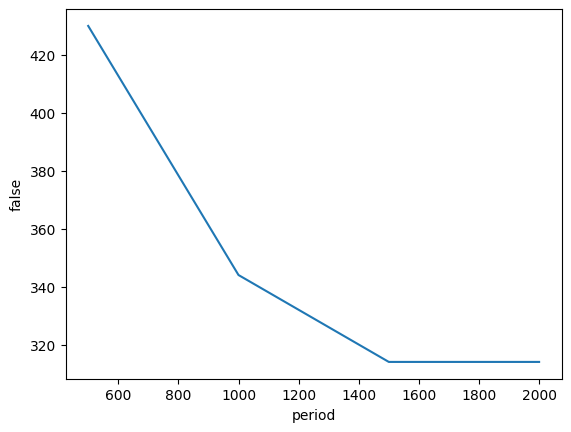

In [98]:
sns.lineplot(data=test_scores.loc[ test_scores['y'] == 'all' ], x='period', y='false')

<Axes: xlabel='period', ylabel='outOfPatternMisclassified'>

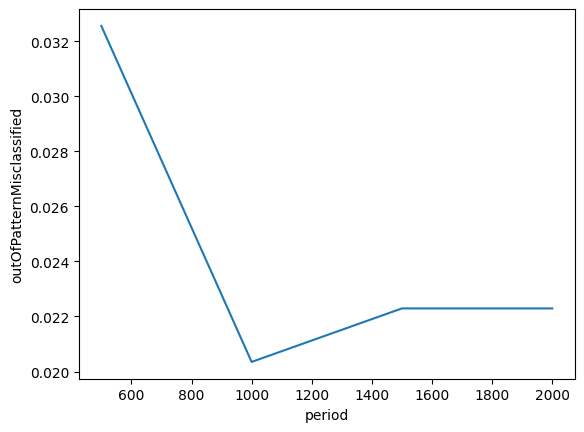

In [99]:
sns.lineplot(data=test_scores.loc[ test_scores['y'] == 'all' ], x='period', y='outOfPatternMisclassified')